In [69]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
%cd /content/drive/MyDrive/credit_details

/content/drive/MyDrive/credit_details


In [72]:
card_info = pd.read_csv('cc_info.csv')
transaction_info = pd.read_csv('transactions.csv')

In [73]:
card_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [74]:
transaction_info.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [75]:
#check for missing values
card_info.isnull().sum()

,0
credit_card,0
city,0
state,0
zipcode,0
credit_card_limit,0


In [76]:
#check for missing values
transaction_info.isnull().sum()

,0
credit_card,0
date,0
transaction_dollar_amount,0
Long,0
Lat,0


In [77]:
# checking for duplicate data in both datasets

# Check for duplicate data in card_info
print("Duplicate rows in card_info:", card_info.duplicated().sum())

# Check for duplicate data in transaction_info
print("Duplicate rows in transaction_info:", transaction_info.duplicated().sum())


Duplicate rows in card_info: 0
Duplicate rows in transaction_info: 0


In [78]:
#merge two dataframes
data = transaction_info.merge(card_info, on = 'credit_card')

In [79]:
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [80]:
print(f"data shape: {data.shape}")
print(f"data size: {data.size}")

data shape: (294588, 9)
data size: 2651292


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   credit_card                294588 non-null  int64  
 1   date                       294588 non-null  object 
 2   transaction_dollar_amount  294588 non-null  float64
 3   Long                       294588 non-null  float64
 4   Lat                        294588 non-null  float64
 5   city                       294588 non-null  object 
 6   state                      294588 non-null  object 
 7   zipcode                    294588 non-null  int64  
 8   credit_card_limit          294588 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 20.2+ MB


In [82]:
data['date'] = pd.to_datetime(data['date'])
# Set 'date' as index for time series analysis
data.set_index('date', inplace=True)

In [83]:
print(f"data shape after cleaning: {data.shape}")
print(f"data size after cleaning: {data.size}")

data shape after cleaning: (294588, 8)
data size after cleaning: 2356704


In [84]:
# Summary statistics for numeric columns
print(data.describe())


        credit_card  transaction_dollar_amount           Long            Lat  \
count  2.945880e+05              294588.000000  294588.000000  294588.000000   
mean   5.424562e+15                  86.008036     -76.235238      40.937669   
std    2.555803e+15                 124.655954      20.135015       5.391695   
min    1.003715e+15                   0.010000    -179.392887     -68.046553   
25%    3.344214e+15                  29.970000     -80.209708      40.487726   
50%    5.353426e+15                  58.470000     -73.199737      42.403066   
75%    7.646245e+15                 100.400000     -72.091933      43.180015   
max    9.999757e+15                 999.970000     179.917513      78.914330   

             zipcode  credit_card_limit  
count  294588.000000      294588.000000  
mean    18073.772516       15502.053716  
std     23945.510551        7956.291556  
min       690.000000        2000.000000  
25%      3280.000000       10000.000000  
50%      5820.000000       

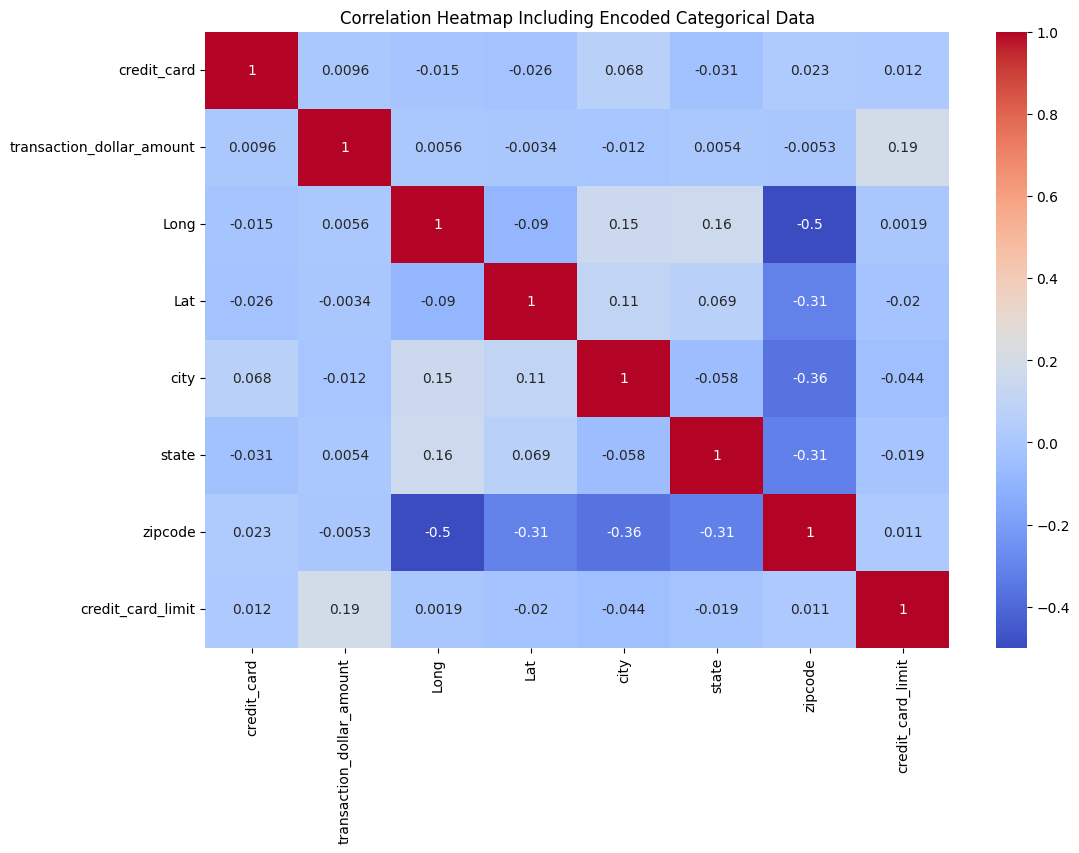

In [85]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the data to avoid changing the original DataFrame
data_encoded = data.copy()

# Identify categorical columns (columns with dtype 'object')
categorical_columns = data_encoded.select_dtypes(include=['object']).columns

# Apply Label Encoding to each categorical column
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    data_encoded[column] = le.fit_transform(data_encoded[column].astype(str))  # Convert to string in case of mixed types
    label_encoders[column] = le

# Now data_encoded contains numeric representations of the original categorical data
# Select only numeric columns for correlation analysis
numeric_columns = data_encoded.select_dtypes(include=[np.number])

# Plot the correlation heatmap including encoded categorical columns
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap Including Encoded Categorical Data')
plt.show()


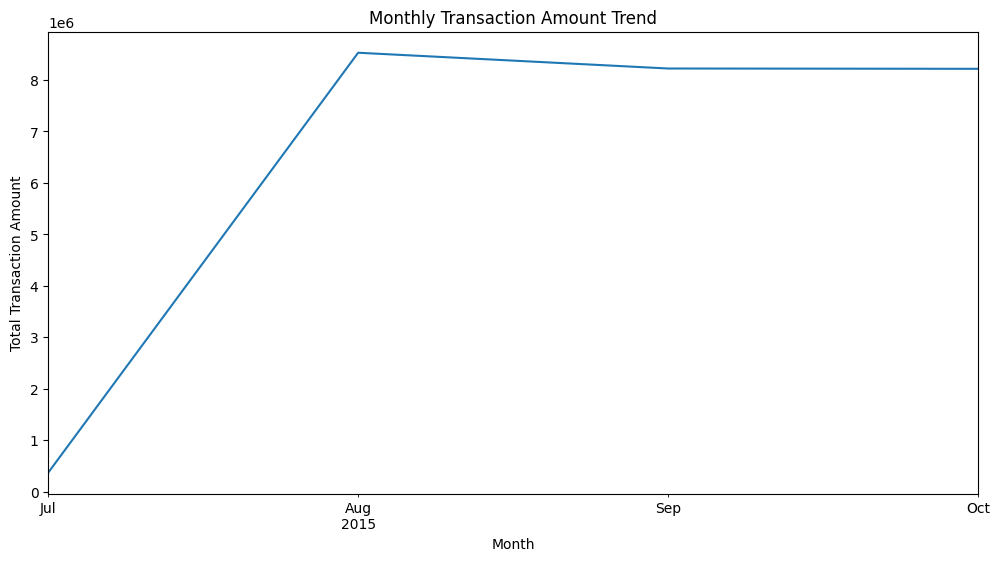

In [86]:
# Monthly Transaction Trend
data['transaction_dollar_amount'].resample('M').sum().plot(figsize=(12, 6))
plt.title('Monthly Transaction Amount Trend')
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount')
plt.show()

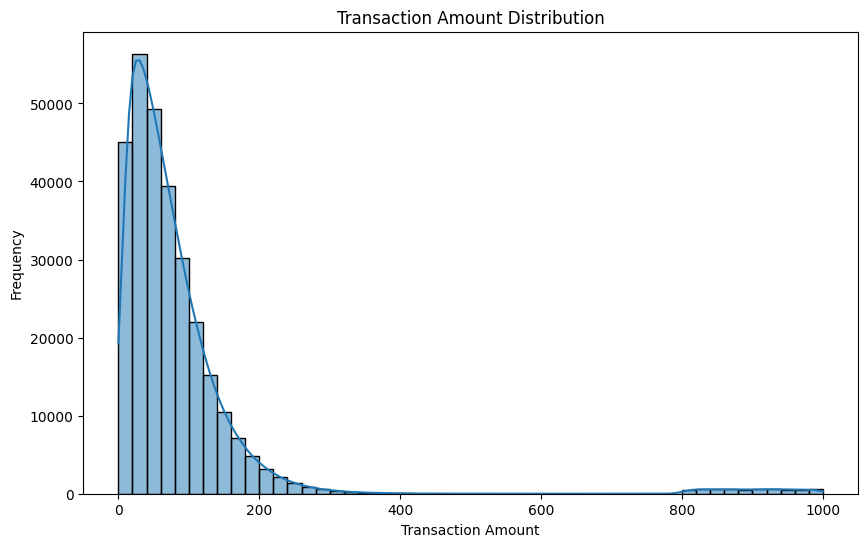

In [87]:
# Distribution of Transaction Amounts
plt.figure(figsize=(10, 6))
sns.histplot(data['transaction_dollar_amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

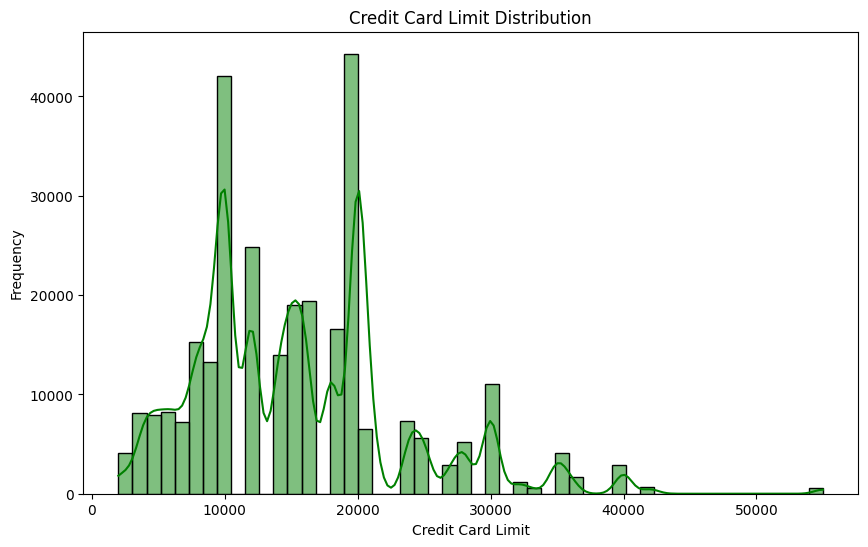

In [88]:
# Distribution of Credit Card Limits
plt.figure(figsize=(10, 6))
sns.histplot(data['credit_card_limit'], bins=50, kde=True, color='green')
plt.title('Credit Card Limit Distribution')
plt.xlabel('Credit Card Limit')
plt.ylabel('Frequency')
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


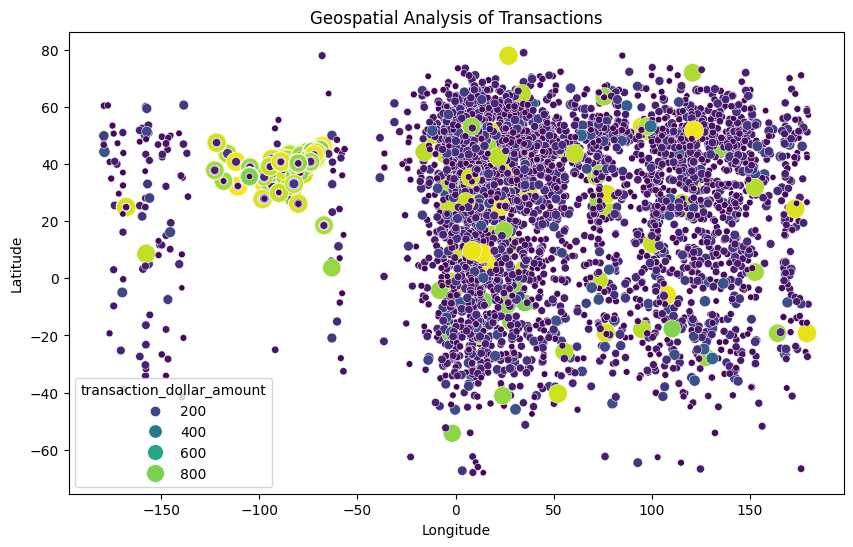

In [89]:
# Geospatial Analysis: Transaction locations
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Long'], y=data['Lat'], hue=data['transaction_dollar_amount'], palette='viridis', size=data['transaction_dollar_amount'], sizes=(20, 200))
plt.title('Geospatial Analysis of Transactions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [90]:
### Feature Engineering

# Creating additional time-based features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [91]:
# Ensure the index is sorted
data.sort_index(inplace=True)

# Calculate transaction velocity
data['transactions_per_hour'] = data.groupby('credit_card')['transaction_dollar_amount'].transform(lambda x: x.rolling('1H').count())

# Calculate rolling average of transaction amounts for the past week
data['rolling_amount_7d'] = data['transaction_dollar_amount'].rolling('7D').mean()

# Calculate ratio of transaction amount to credit limit
data['amount_per_limit'] = data['transaction_dollar_amount'] / data['credit_card_limit']


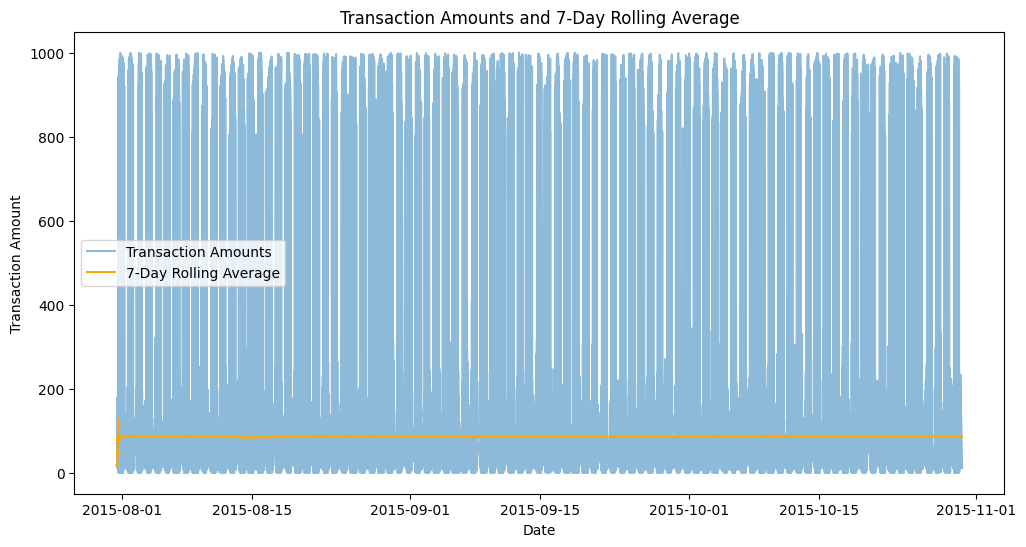

In [92]:
import matplotlib.pyplot as plt

# Ensure the DataFrame is sorted by datetime index
data.sort_index(inplace=True)

# Plot the rolling average of transaction amounts
plt.figure(figsize=(12, 6))

# Plot the raw transaction amounts
plt.plot(data.index, data['transaction_dollar_amount'], label='Transaction Amounts', alpha=0.5)

# Plot the rolling average
plt.plot(data.index, data['rolling_amount_7d'], label='7-Day Rolling Average', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.title('Transaction Amounts and 7-Day Rolling Average')
plt.legend()

# Show the plot
plt.show()


In [93]:
# Aggregating data to create cardholder-level features
card_features = data.groupby('credit_card').agg(
    avg_transaction_amount=('transaction_dollar_amount', 'mean'),
    total_transaction_amount=('transaction_dollar_amount', 'sum'),
    transaction_count=('transaction_dollar_amount', 'count'),
    avg_amount_per_limit=('amount_per_limit', 'mean'),
    avg_transactions_per_hour=('transactions_per_hour', 'mean')
).reset_index()

# Merging cardholder-level features back to the original data
data = data.merge(card_features, on='credit_card', how='left')


In [94]:
# Assuming 'transaction_dollar_amount' and 'credit_card' are columns in your DataFrame

# Average transaction amount per credit card
data['avg_transaction_amount'] = data.groupby('credit_card')['transaction_dollar_amount'].transform('mean')

# Total transaction amount per credit card
data['total_transaction_amount'] = data.groupby('credit_card')['transaction_dollar_amount'].transform('sum')

# Transaction count per credit card
data['transaction_count'] = data.groupby('credit_card')['transaction_dollar_amount'].transform('count')


In [95]:
### Scaling and Data Preparation

# Features for scaling
features = ['transaction_dollar_amount', 'credit_card_limit', 'avg_transaction_amount',
            'total_transaction_amount', 'transaction_count', 'amount_per_limit',
            'hour', 'day_of_week', 'is_weekend', 'transactions_per_hour', 'rolling_amount_7d']

X = data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Splitting the dataset while keeping track of indices
X_train, X_test, train_idx, test_idx = train_test_split(X_scaled, data.index, test_size=0.3, random_state=42)

In [96]:
# Check the number of rows in the test set
num_rows_test = X_train.shape[0]
print(f'The number of rows in the test set is: {num_rows_test}')

The number of rows in the test set is: 206211


In [97]:
# Check the number of rows in the test set
num_rows_test = X_test.shape[0]
print(f'The number of rows in the test set is: {num_rows_test}')

The number of rows in the test set is: 88377


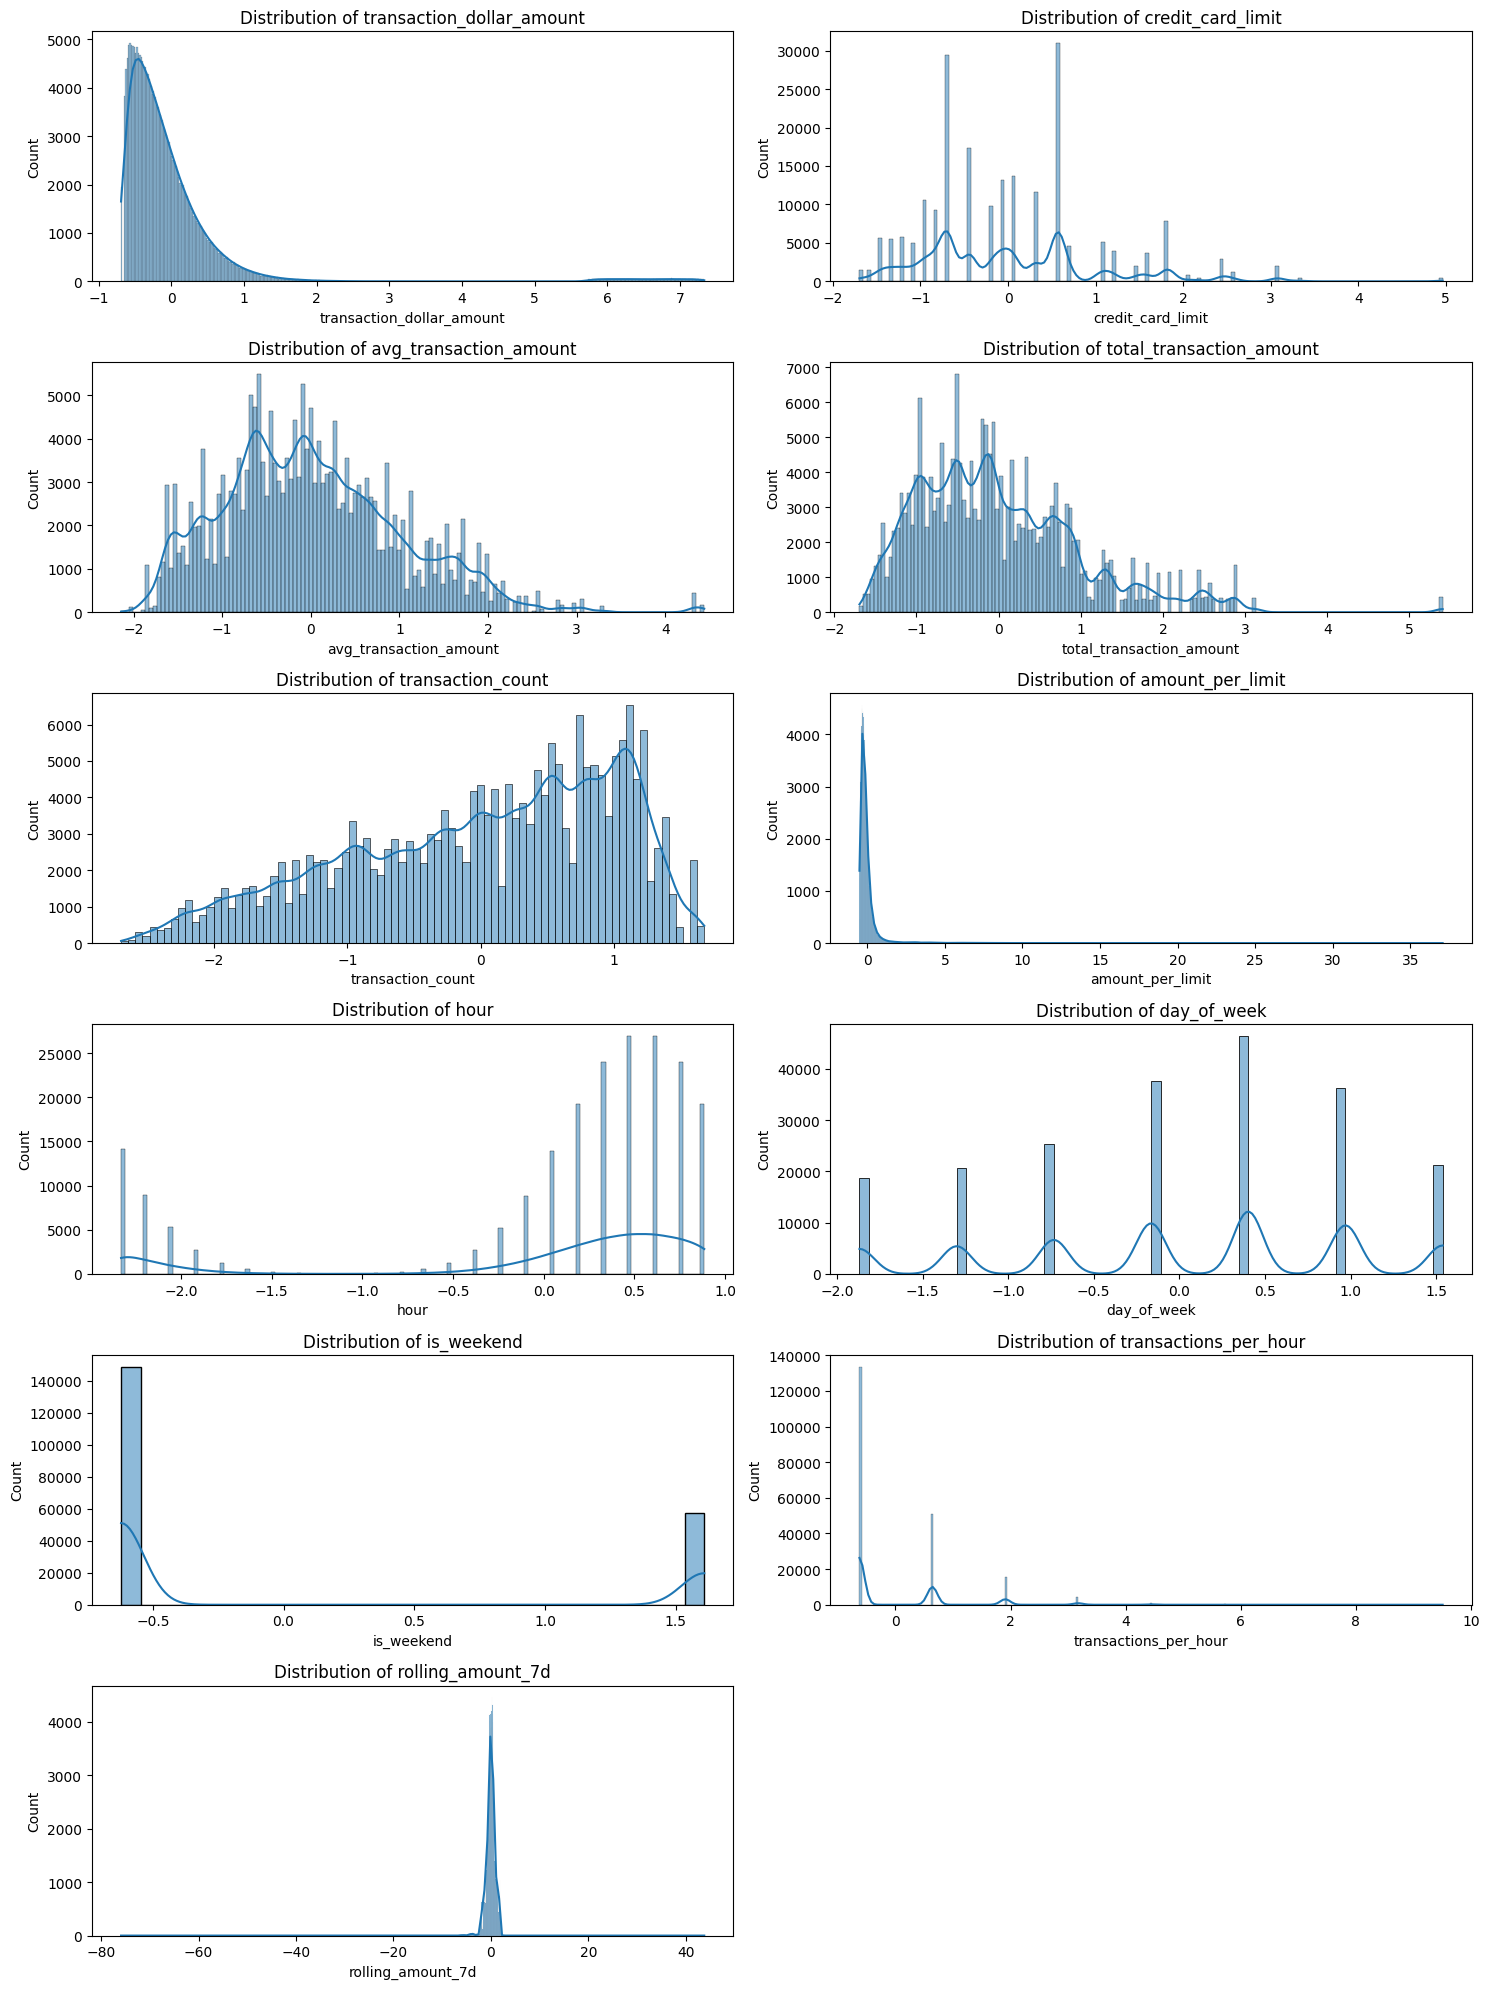

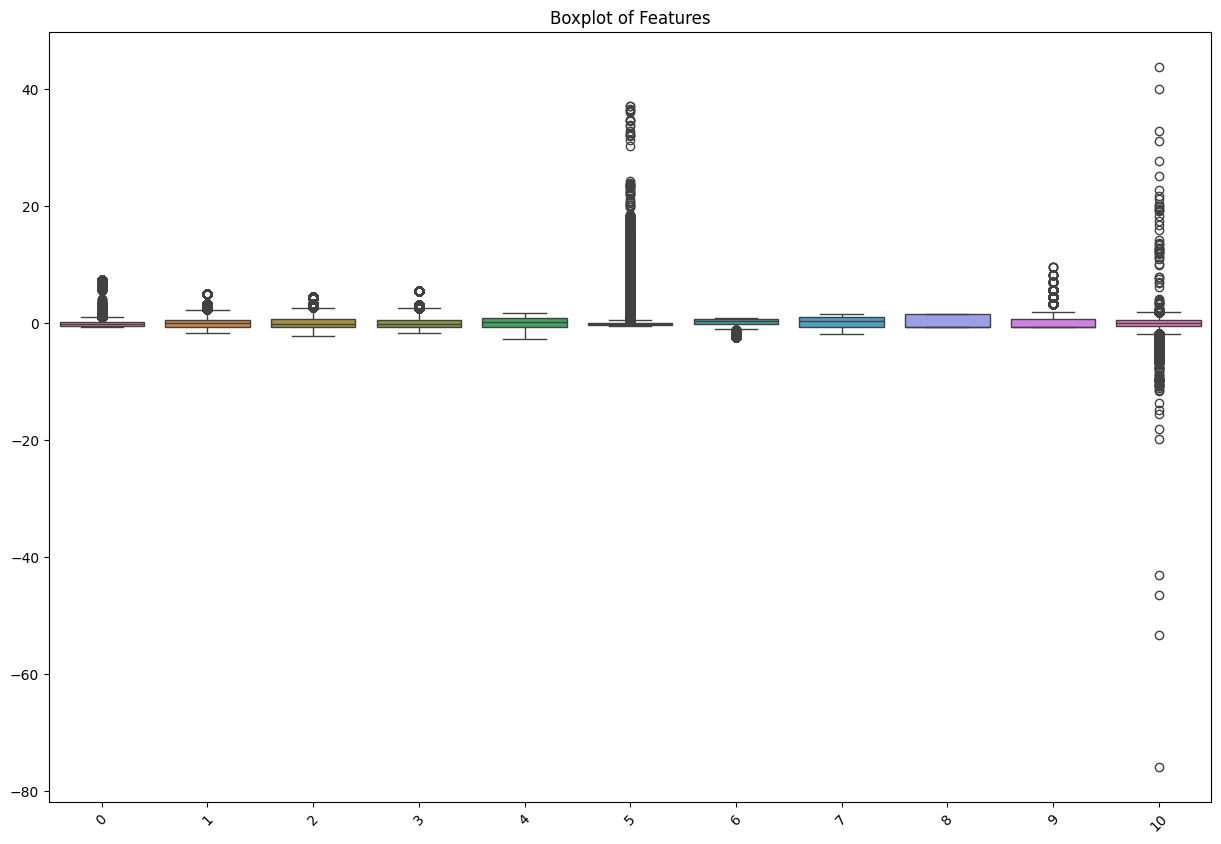

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train is your dataset
# You can adjust the figsize based on the number of features (e.g., 11 features)
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15, 20)) # Increased number of rows to 6 to accommodate 11 features

# Use the 'features' list to access column names since X_train is a NumPy array
for i, feature in enumerate(features):
    # Histogram for distribution
    sns.histplot(X_train[:, i], kde=True, ax=axs[i//2, i%2])  # Access columns by index
    axs[i//2, i%2].set_title(f'Distribution of {feature}')
    axs[i//2, i%2].set_xlabel(feature)
# Remove the extra empty subplot
fig.delaxes(axs[5, 1])
plt.tight_layout()
plt.show()

# Box plot to observe variance and detect outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=X_train)
plt.title('Boxplot of Features')
plt.xticks(rotation=45)
plt.show()

In [99]:
X_train.shape

(206211, 11)

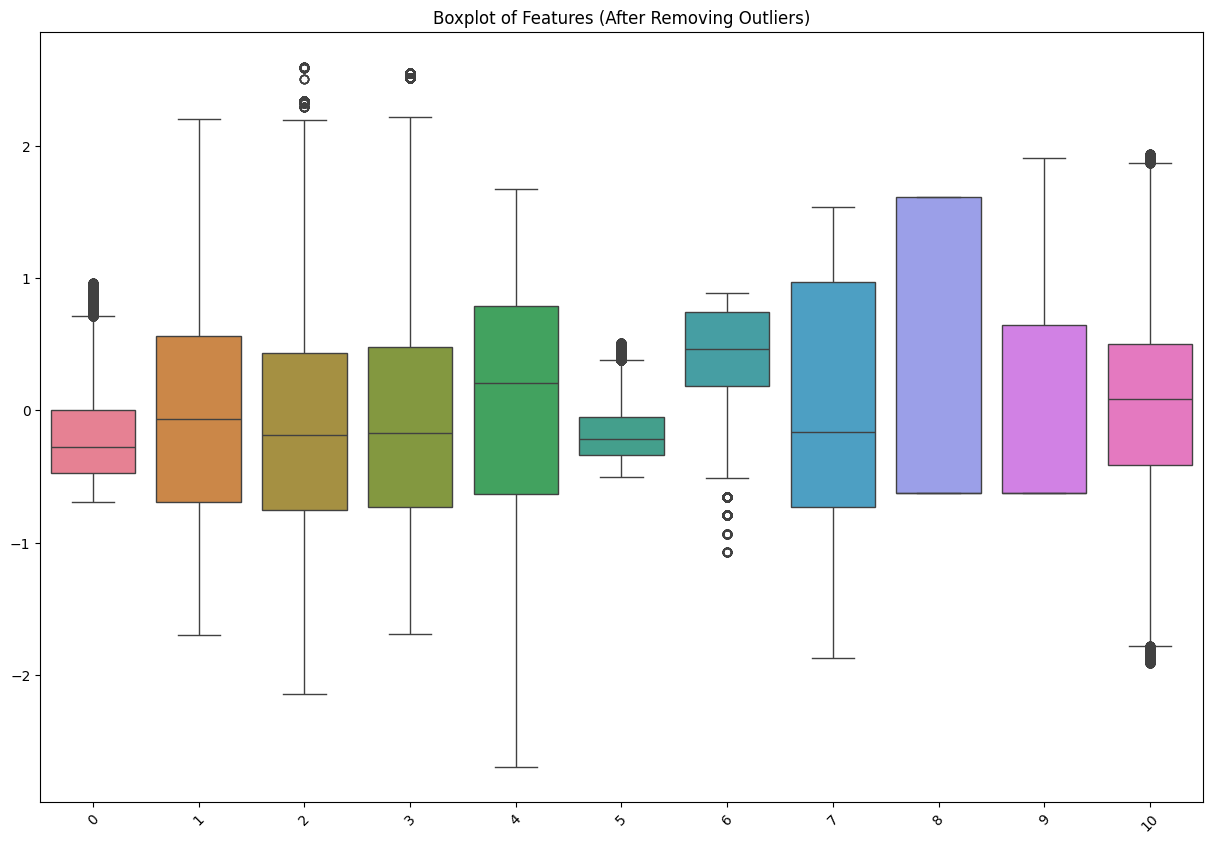

In [100]:
import numpy as np
import pandas as pd

# Converting X_train back to a DataFrame for easier manipulation
X_train_df = pd.DataFrame(X_train, columns=features)

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each feature
Q1 = X_train_df.quantile(0.25)
Q3 = X_train_df.quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
# This condition returns True if all features are within bounds for a given row
non_outliers = ~((X_train_df < lower_bound) | (X_train_df > upper_bound)).any(axis=1)

# Remove outliers from X_train
X_train_no_outliers = X_train_df[non_outliers].to_numpy()

# Optionally, keep track of the indices of the non-outlier rows for reference
non_outliers_indices = train_idx[non_outliers]

# Plot the boxplot again after removing outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=X_train_no_outliers)
plt.title('Boxplot of Features (After Removing Outliers)')
plt.xticks(rotation=45)
plt.show()


In [101]:
X_train_no_outliers.shape

(142162, 11)

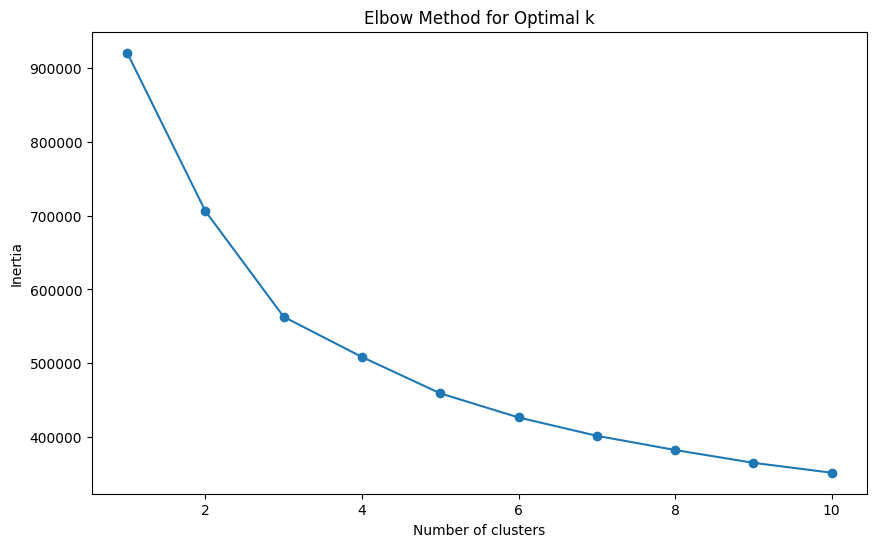

In [102]:
### 1. Optimize K-Means Clustering

# Elbow Method to determine optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_no_outliers)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Choosing optimal k (e.g., 4 or 5)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_train_no_outliers)

# Predict cluster labels and distances to cluster center
train_clusters = kmeans.predict(X_train_no_outliers)
test_clusters = kmeans.predict(X_test)

train_distances = np.linalg.norm(X_train_no_outliers - kmeans.cluster_centers_[train_clusters], axis=1)
test_distances = np.linalg.norm(X_test - kmeans.cluster_centers_[test_clusters], axis=1)

# Flag anomalies using the 95th percentile distance threshold
distance_threshold_train = np.percentile(train_distances, 95)
distance_threshold_test = np.percentile(test_distances, 95)

train_anomalies_kmeans = train_distances > distance_threshold_train
test_anomalies_kmeans = test_distances > distance_threshold_test

In [103]:
# best_iso_forest.fit(X_train_no_outliers)
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
import warnings
# More comprehensive parameter grid
param_grid = {
    'n_estimators': [100],
    'max_samples': [0.8],
    'contamination': [0.05],
    'max_features': [1.0],
    'bootstrap': [True, False]
}

iso_forest = IsolationForest(random_state=42)

# Use scoring='neg_mean_squared_error' for unsupervised learning
grid = GridSearchCV(iso_forest, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
# Suppress warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    grid.fit(X_train_no_outliers)

# Best parameters
best_iso_forest = grid.best_estimator_
print(f"Best Isolation Forest parameters: {grid.best_params_}")

# Fit and predict with optimized Isolation Forest
best_iso_forest.fit(X_train_no_outliers)
train_anomaly_scores = best_iso_forest.decision_function(X_train_no_outliers)
test_anomaly_scores = best_iso_forest.decision_function(X_test)

train_anomalies_iforest = best_iso_forest.predict(X_train_no_outliers) == -1
test_anomalies_iforest = best_iso_forest.predict(X_test) == -1


Best Isolation Forest parameters: {'bootstrap': True, 'contamination': 0.05, 'max_features': 1.0, 'max_samples': 0.8, 'n_estimators': 100}


In [104]:
### 3. Additional Anomaly Detection Methods (LOF and One-Class SVM)

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
train_anomalies_lof = lof.fit_predict(X_train_no_outliers) == -1
test_anomalies_lof = lof.fit_predict(X_test) == -1

# One-Class SVM
ocsvm = OneClassSVM(gamma='auto', nu=0.01)
ocsvm.fit(X_train_no_outliers)
train_anomalies_ocsvm = ocsvm.predict(X_train_no_outliers) == -1
test_anomalies_ocsvm = ocsvm.predict(X_test) == -1


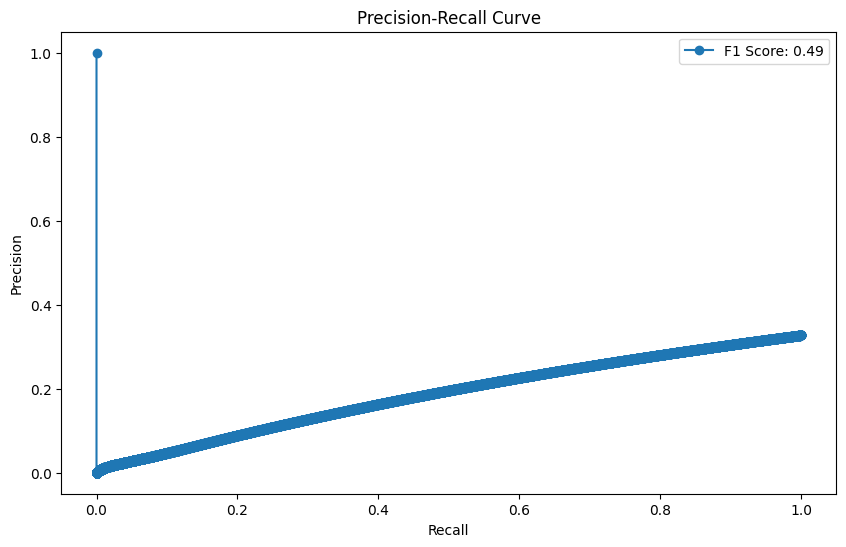

In [105]:
### 4. Ensemble Approach for Anomaly Detection

# Combine multiple methods for final fraud flagging
final_train_anomalies = (train_anomalies_kmeans | train_anomalies_iforest | train_anomalies_lof | train_anomalies_ocsvm)
final_test_anomalies = (test_anomalies_kmeans | test_anomalies_iforest | test_anomalies_lof | test_anomalies_ocsvm)

# Evaluate model using precision-recall curve
precision, recall, thresholds = precision_recall_curve(final_test_anomalies, test_anomaly_scores)
epsilon = 1e-10  # small constant
f1 = 2 * (precision * recall) / (precision + recall + epsilon)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='o', label=f'F1 Score: {np.max(f1):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [106]:
# ROC-AUC Plot for each model

def plot_roc_auc(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Comparison')
    plt.grid(True)

    # Add the legend after plotting multiple lines
    plt.legend(loc='lower right')

plt.figure(figsize=(10, 8))


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

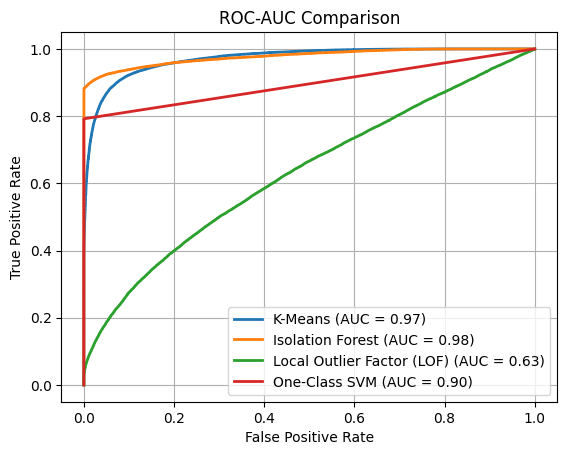

In [107]:
# K-Means ROC-AUC
plot_roc_auc(final_test_anomalies, test_distances, 'K-Means')

# Isolation Forest ROC-AUC
plot_roc_auc(final_test_anomalies, -test_anomaly_scores, 'Isolation Forest')

# LOF ROC-AUC
plot_roc_auc(final_test_anomalies, -lof.negative_outlier_factor_, 'Local Outlier Factor (LOF)')
# OCSVM ROC-AUC
plot_roc_auc(final_test_anomalies, test_anomalies_ocsvm, 'One-Class SVM')

Summary of Anomaly Detection Results
Total number of anomalies detected by K-Means:  4419
Total number of anomalies detected by Isolation Forest:  25515
Total number of anomalies detected by LOF:  884
Total number of anomalies detected by One-Class SVM:  22910
Total number of anomalies detected by the Ensemble approach:  28927


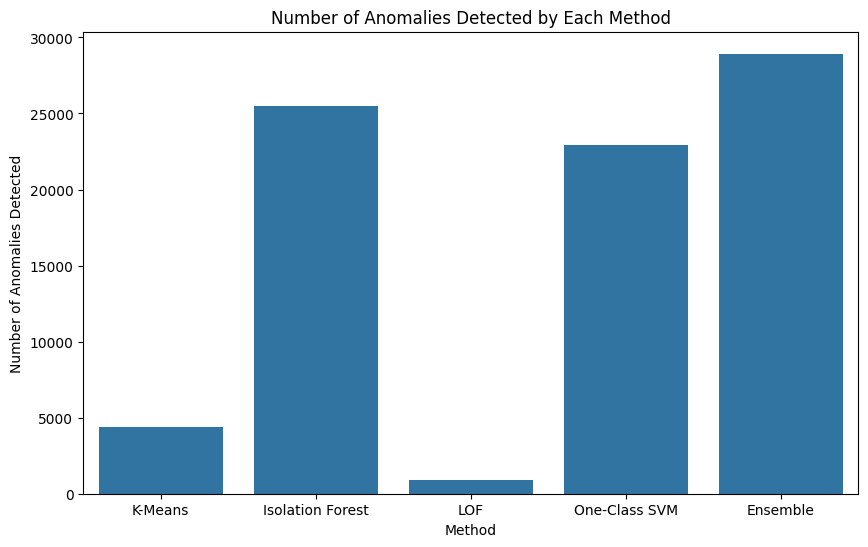

Displaying a few flagged transactions:
             credit_card  transaction_dollar_amount  is_fraud
191870  3951632727431524                     303.34      True
117965  8822567299944562                      26.07      True
209473  9755306333757844                      66.67      True
73087   7081424943873587                      86.71      True
10057   9194498820553808                      49.95      True
63678   3662455495779947                      98.41      True
194805  7195601645654041                     135.60      True
225839  1261411767321605                     290.87      True
172085  1688895281144247                      53.60      True
87379   5996982621454469                     853.28      True
Flagged transactions have been saved to 'flagged_fraud_transactions.csv'.


In [108]:
# Print summary of the results
print("Summary of Anomaly Detection Results")

# Summary of flagged anomalies
print("Total number of anomalies detected by K-Means: ", np.sum(test_anomalies_kmeans))
print("Total number of anomalies detected by Isolation Forest: ", np.sum(test_anomalies_iforest))
print("Total number of anomalies detected by LOF: ", np.sum(test_anomalies_lof))
print("Total number of anomalies detected by One-Class SVM: ", np.sum(test_anomalies_ocsvm))
print("Total number of anomalies detected by the Ensemble approach: ", np.sum(final_test_anomalies))

# Plot summary of the anomalies detected by each method
methods = ['K-Means', 'Isolation Forest', 'LOF', 'One-Class SVM', 'Ensemble']
anomalies_count = [
    np.sum(test_anomalies_kmeans),
    np.sum(test_anomalies_iforest),
    np.sum(test_anomalies_lof),
    np.sum(test_anomalies_ocsvm),
    np.sum(final_test_anomalies)
]

plt.figure(figsize=(10, 6))
sns.barplot(x=methods, y=anomalies_count)
plt.title('Number of Anomalies Detected by Each Method')
plt.xlabel('Method')
plt.ylabel('Number of Anomalies Detected')
plt.show()
# Create an empty column for 'is_fraud' in the full data set
data['is_fraud'] = False  # Initialize all to False


# Assign the anomaly results back to the corresponding rows in the original dataset
data.loc[test_idx, 'is_fraud'] = final_test_anomalies  # Assign anomalies to test set indices

### 3. Display flagged transactions
# Filter the flagged transactions (anomalies) from the original dataset
fraud_transactions = data.loc[test_idx][final_test_anomalies]  # Filter the rows flagged as anomalies

# Display a few flagged transactions
print("Displaying a few flagged transactions:")
print(fraud_transactions[['credit_card', 'transaction_dollar_amount', 'is_fraud']].head(10))
# Save flagged transactions to a CSV file for further review
fraud_transactions.to_csv('flagged_fraud_transactions.csv', index=False)
print("Flagged transactions have been saved to 'flagged_fraud_transactions.csv'.")

